In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
import PIL
import cv2
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [2]:
IMG_SAVE_PATH_Test = 'dataset/test'

# Get a list of folder names in the directory
folders = [name for name in os.listdir(IMG_SAVE_PATH_Test) if os.path.isdir(os.path.join(IMG_SAVE_PATH_Test, name))]

# Create a dictionary with index as key and folder name as value
folders_dict = {folder: index for index, folder in enumerate(folders)}
folders_dict

{'Almonds': 0,
 'Biscuits': 1,
 'Chocolate': 2,
 'lays': 3,
 'maggi': 4,
 'oats': 5,
 'penutbutter': 6,
 'Soup': 7}

In [3]:
IMG_SAVE_PATH_Train = 'dataset/train'
IMG_SAVE_PATH_Test = 'dataset/test'
Str_to_Int =folders_dict

NUM_CLASSES = 8
def str_to_Int_mapper(val):
    return Str_to_Int[val]

def preprocess(IMG_SAVE_PATH):
    dataset = []
    for directory in os.listdir(IMG_SAVE_PATH):
        path = os.path.join(IMG_SAVE_PATH, directory)
        for image in os.listdir(path):
            new_path = os.path.join(path, image)
            try:
                imgpath=PIL.Image.open(new_path)
                imgpath=imgpath.convert('RGB')
                img = np.asarray(imgpath)
                img = cv2.resize(img, (331,331))
                img=img/255.
                dataset.append([img, directory])
            except FileNotFoundError:
                print('Image file not found. Skipping...')
    return dataset


In [4]:
traindata=preprocess(IMG_SAVE_PATH_Train)

In [5]:
testdata=preprocess(IMG_SAVE_PATH_Test)

In [6]:
xtrain, labelstrain = zip(*traindata)
xtest, labelstest = zip(*testdata)

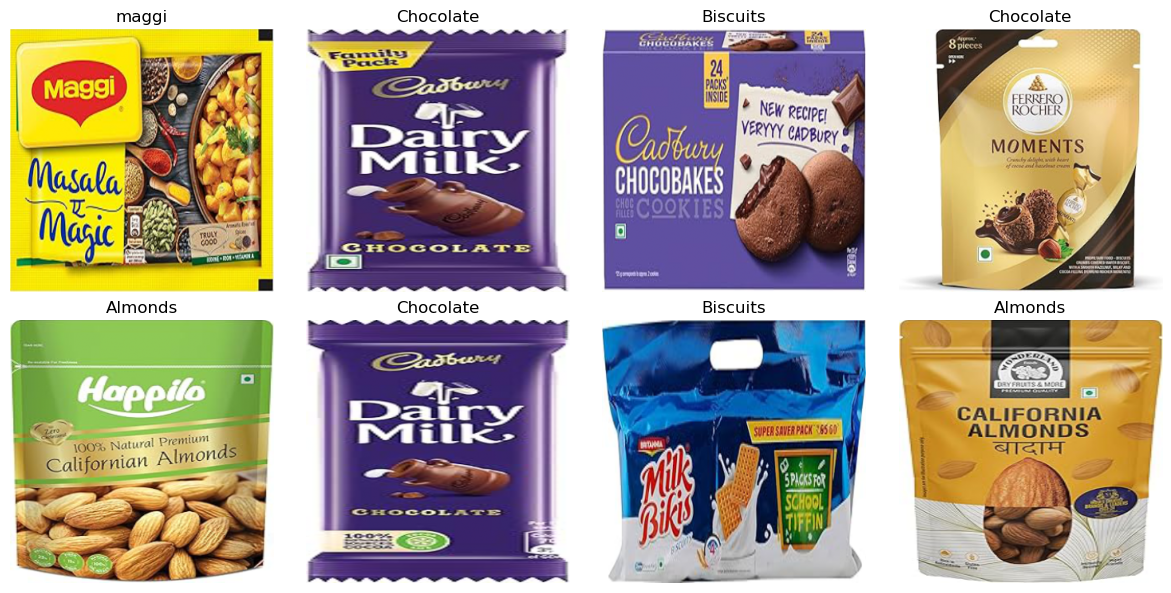

In [7]:

import matplotlib.pyplot as plt
import random

# Randomly select 8 indices from the dataset
indices = random.sample(range(len(xtrain)), 8)

# Set up the plot grid
plt.figure(figsize=(12, 6))

# Loop through the selected indices
for i, idx in enumerate(indices):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    plt.imshow(xtrain[idx])  # Assuming data[idx] is an image
    plt.title(labelstrain[idx])
    plt.axis('off')

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
set(labelstrain),set(labelstest)


({'Almonds',
  'Biscuits',
  'Chocolate',
  'Soup',
  'lays',
  'maggi',
  'oats',
  'penutbutter'},
 {'Almonds',
  'Biscuits',
  'Chocolate',
  'Soup',
  'lays',
  'maggi',
  'oats',
  'penutbutter'})

In [9]:
temp = list(map(str_to_Int_mapper, labelstrain))
ytrain = tensorflow.keras.utils.to_categorical(temp)
temp1 = list(map(str_to_Int_mapper, labelstest))
ytest = tensorflow.keras.utils.to_categorical(temp1)

In [10]:
xtrain=np.array(xtrain)
xtest=np.array(xtest)
ytrain=np.array(ytrain)
ytest=np.array(ytest)

In [11]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((148, 331, 331, 3), (150, 331, 331, 3), (148, 8), (150, 8))

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

# Custom CNN model definition
def create_custom_cnn(input_shape=(331, 331, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3))(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)  # Flatten to create a 1D vector
    custom_cnn_model = Model(inputs, x)

    return custom_cnn_model

# Base model (InceptionResNetV2) definition
def create_combined_model(num_classes=8, cnn_input_shape=(331, 331, 3), inception_input_shape=(331, 331, 3)):
    # Custom CNN model
    custom_cnn = create_custom_cnn(input_shape=cnn_input_shape)

    # Pretrained InceptionResNetV2 (without top layers)
    base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                         weights='imagenet',
                                                         input_shape=inception_input_shape)
    base_model.trainable = False  # Freeze InceptionResNetV2 layers

    # Flatten the output of the base model (InceptionResNetV2)
    inception_output = Flatten()(base_model.output)

    # Concatenate the output of custom CNN and InceptionResNetV2
    concatenated = Concatenate()([custom_cnn.output, inception_output])

    # Add dense layers after concatenation
    x = Dense(512, activation='relu')(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)

    # Output layer (adjust the output for the number of classes)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=[custom_cnn.input, base_model.input], outputs=output)

    return model

# Instantiate the model
model = create_combined_model(num_classes=8)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the combined model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 331, 331, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 165, 165, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 165, 165, 32)      │              96 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 165, 165, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 163, 163, 32)      │           9,216 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 163, 163, 32)      │              96 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_4 (Activation)     │ (None, 163, 163, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 163, 163, 64)      │          18,432 │ activation_4[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 163, 163, 64)      │             192 │ conv2d_5[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 163, 163, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 81, 81, 64)        │               0 │ activation_5[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 81, 81, 80)        │           5,120 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 81, 81, 80)        │             240 │ conv2d_6[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 81, 81, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 79, 79, 192)       │         138,24

 Total params: 168,072,264 (641.14 MB)

 Trainable params: 113,735,528 (433.87 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 activation_24 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 39, 39, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_25 (Conv2D)             (None, 39, 39, 48)   13824       ['activation_24[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 39, 39, 32)  96          ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 39, 39, 48)  144         ['conv2d_25[0][0]']              
 ormalizat

                                                                                                  
 activation_27 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_32 (Activation)     (None, 39, 39, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 39, 39, 128)  0           ['activation_27[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'activation_32[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 39, 39, 48)  144         ['conv2d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_40 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_43 (Activation)     (None, 39, 39, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 39, 39, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 39, 39, 128)  0           ['activation_45[0][0]',          
                                                                  'activation_47[0][0]',          
                                                                  'activation_50[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 39, 39, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 39, 39, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 39, 39, 320)  0           ['block35_6[0][0]']              
          

 activation_61 (Activation)     (None, 39, 39, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_57 (Conv2D)             (None, 39, 39, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_59 (Conv2D)             (None, 39, 39, 32)   9216        ['activation_58[0][0]']          
                                                                                                  
 conv2d_62 (Conv2D)             (None, 39, 39, 64)   27648       ['activation_61[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 39, 39, 32)  96          ['conv2d_57[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 39, 39, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_72 (Conv2D)             (None, 39, 39, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 39, 39, 32)  96          ['conv2d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 39, 39, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_78 (Activation)     (None, 19, 19, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 19, 19, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 19, 19, 1088  0           ['activation_75[0][0]',          
                                )                                 'activation_78[0][0]',          
                                                                  'max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_80 (Conv2D)             (None, 19, 19, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 19, 19, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 19, 19, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 19, 19, 128)  384        ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_96 (Conv2D)             (None, 19, 19, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 19, 19, 128)  384        ['conv2d_96[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_96 (Activation)     (None, 19, 19, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 19, 19, 160)  143360      ['activation_96[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 19, 19, 128)  384        ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_104 (Activation)    (None, 19, 19, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_105 (Conv2D)            (None, 19, 19, 160)  143360      ['activation_104[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 19, 19, 160)  480        ['conv2d_105[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_112 (Activation)    (None, 19, 19, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_113 (Conv2D)            (None, 19, 19, 160)  143360      ['activation_112[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 19, 19, 160)  480        ['conv2d_113[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_113 (Activation)    (None, 19, 19, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_11

 conv2d_121 (Conv2D)            (None, 19, 19, 160)  143360      ['activation_120[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 19, 19, 160)  480        ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_121 (Activation)    (None, 19, 19, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_119 (Conv2D)            (None, 19, 19, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_122 (Conv2D)            (None, 19, 19, 192)  215040      ['activation_121[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_129 (Activation)    (None, 19, 19, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_127 (Conv2D)            (None, 19, 19, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_130 (Conv2D)            (None, 19, 19, 192)  215040      ['activation_129[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 19, 19, 192)  576        ['conv2d_127[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_135 (Conv2D)            (None, 19, 19, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_138 (Conv2D)            (None, 19, 19, 192)  215040      ['activation_137[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 19, 19, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 19, 19, 192)  576        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
          

 conv2d_146 (Conv2D)            (None, 19, 19, 192)  215040      ['activation_145[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 19, 19, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 19, 19, 192)  576        ['conv2d_146[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_143 (Activation)    (None, 19, 19, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 19, 19, 192)  576        ['conv2d_154[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_151 (Activation)    (None, 19, 19, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_154 (Activation)    (None, 19, 19, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 19, 19, 384)  0          ['activation_151[0][0]',         
          

 activation_159 (Activation)    (None, 19, 19, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 19, 19, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_164 (Activation)    (None, 19, 19, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_160 (Conv2D)            (None, 9, 9, 384)    884736      ['activation_159[0][0]']         
                                                                                                  
 conv2d_162 (Conv2D)            (None, 9, 9, 288)    663552      ['activation_161[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_172 (Activation)    (None, 9, 9, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_170 (Conv2D)            (None, 9, 9, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_173 (Conv2D)            (None, 9, 9, 256)    172032      ['activation_172[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 9, 9, 192)   576         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 9, 9, 192)   576         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 9, 9, 256)   768         ['conv2d_181[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_178 (Activation)    (None, 9, 9, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_181 (Activation)    (None, 9, 9, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_189 (Activation)    (None, 9, 9, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 9, 9, 448)    0           ['activation_186[0][0]',         
                                                                  'activation_189[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 9, 9, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 9, 9, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 9, 9, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 9, 9, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_199 (Conv2D)            (None, 9, 9, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 9, 9, 192)   576         ['conv2d_199[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_1 (Conv2D)              (None, 162, 162, 32  9248        ['max_pooling2d[0][0]']          
                                )                                                                 
                                                                                                  
 block8_10_mixed (Concatenate)  (None, 9, 9, 448)    0           ['activation_202[0][0]',         
                                                                  'activation_205[0][0]']         
                                                                                                  
 activation_1 (Activation)      (None, 162, 162, 32  0           ['conv2d_1[0][0]']               
                                )                                                                 
                                                                                                  
 block8_10

In [13]:
# early stopping call back
early = tf.keras.callbacks.EarlyStopping(patience = 10,
                                         min_delta = 0.001,
                                         restore_best_weights = True)

batch_size = 2
epochs = 10

history = model.fit(
    [xtrain, xtrain], ytrain,
    epochs=epochs,
    validation_data=([xtest, xtest], ytest),
    verbose=1

)
model.save('foodlabel.h5')

Epoch 1/10


C:\Users\sathi\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 153s 26s/step - accuracy: 0.1847 - loss: 17.9575 - val_accuracy: 0.5267 - val_loss: 8.8506
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 17s/step - accuracy: 0.4198 - loss: 14.2852 - val_accuracy: 0.6467 - val_loss: 2.9283
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.4936 - loss: 7.6835 - val_accuracy: 0.8533 - val_loss: 1.4215
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 16s/step - accuracy: 0.6961 - loss: 4.8363 - val_accuracy: 0.9133 - val_loss: 0.9169
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 16s/step - accuracy: 0.6775 - loss: 4.4201 - val_accuracy: 0.9467 - val_loss: 0.3313
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.8808 - loss: 1.1929 - val_accuracy: 0.9467 - val_loss: 0.3851
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 97s 18s/step - accuracy: 0.8157 - loss: 1.9968 - val_accuracy: 0.9333 - val_loss: 0.4809
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 97s 20s/step - accuracy: 0.8988 - loss: 1.2099 - val_accuracy: 0.9667 - val_loss: 0.1196
Epoch 9/

In [14]:
train_accuracy=[]
val_accuracy=[]
train_loss=[]
val_loss=[]

In [15]:
train_accuracy.extend(history.history['accuracy'])
val_accuracy.extend(history.history['val_accuracy'])
train_loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])


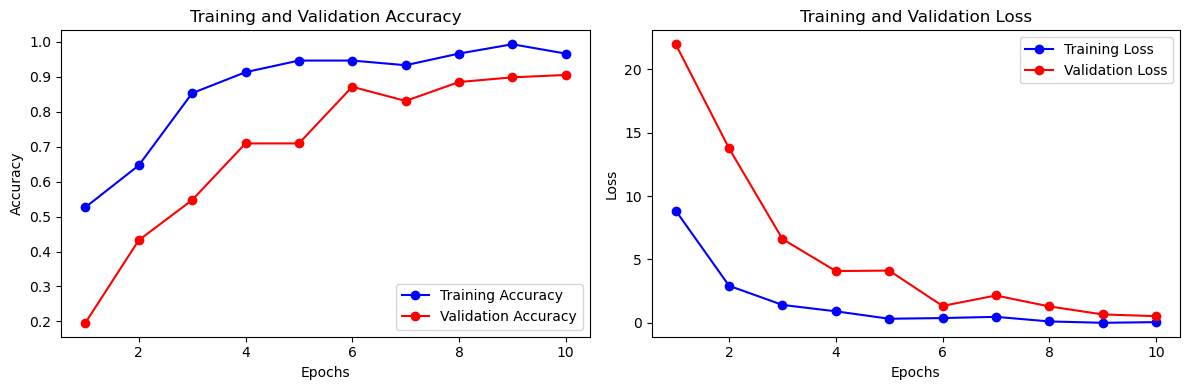

In [16]:
epochs = range(1, len(train_accuracy) + 1)
# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, train_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, 'bo-', label='Training Loss')
plt.plot(epochs, train_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()